# Sentiment Analysis with Logistic Regression and Naive Bayes (No PCA or Stopword Removal)

In this notebook, we explore baseline approaches for sentiment analysis on a dataset of movie reviews. Specifically, we implement and evaluate two widely used classifiers: **Logistic Regression** and **Multinomial Naive Bayes**. The text data undergoes essential cleaning steps such as lowercasing, punctuation removal, and lemmatization, but we intentionally **retain stopwords** and **do not apply dimensionality reduction**. This allows us to assess the models' performance under minimal preprocessing conditions. We employ both **Bag of Words (BoW)** and **TF-IDF** representations for feature extraction and compare the models based on accuracy and other evaluation metrics. The results from this notebook will serve as a reference point for comparison with more advanced techniques in subsequent analyses.

## 1. Import libraries

In [1]:
#Libraries
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk # Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.preprocessing import LabelBinarizer
from wordcloud import WordCloud, STOPWORDS  # To create word cloud visualizations from text
from nltk.stem import WordNetLemmatizer  # For lemmatization
from nltk.tokenize import word_tokenize, sent_tokenize  # For word and sentence tokenization
from bs4 import BeautifulSoup  # For HTML and XML parsing (web scraping)
import spacy  # Fast and efficient NLP library
import re, string, unicodedata  # For string manipulation and text normalization
from nltk.tokenize.toktok import ToktokTokenizer  # More efficient tokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer  # Alternatives for stemming and lemmatization
from sklearn.linear_model import LogisticRegression, SGDClassifier  # Logistic regression and SGD classifiers for classification
from sklearn.naive_bayes import MultinomialNB  # Classification using Naive Bayes
from textblob import TextBlob  # For text and sentiment analysis
from textblob import Word  # For word processing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For model evaluation
import time  # For measuring code execution time

import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

## 2. Dataset

In this chapter, we provide a comprehensive overview of the dataset used for **sentiment analysis**. 
The dataset consists of **movie reviews** labeled as **positive** or **negative**, with a balanced class distribution. 
Each record includes a textual review and its corresponding sentiment label.

In [2]:
imdb_dataset = pd.read_csv('C:/Users/Nosse/IMDBDataset.csv') #load data
print(imdb_dataset.shape)
imdb_dataset.head(16)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


#### Dataset OVERVIEW:

In [3]:
imdb_dataset.describe() #dataset summary

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
imdb_dataset['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

## 3. Pre-Processing : Cleaning-Text

Before training any machine learning model, it is essential to clean and standardize the text data. In this section, we apply several **preprocessing** steps to the movie reviews, including **removing punctuation** and **special characters**, and **remove HTML tags**. These steps help reduce noise in the data and ensure more consistent and meaningful feature extraction in later stages.

### 3.1 Remove HTML tags & Noise from the text

In [5]:
#remove html from text
def remove_html(text):
    
    if not isinstance(text, str):
        text = str(text)
        
    ss = BeautifulSoup(text, "html.parser")
    return ss.get_text()
    
#remove text between square brackets
def remove_btw_square_bb(text):
    return re.sub(r'\[[^]]*\]','',text)

#call all the function to clean text
def remove_noise_txt(text):
    text = remove_html(text)
    text = remove_btw_square_bb(text)
    return text

#apply the function
imdb_dataset['review']= imdb_dataset['review'].apply(remove_noise_txt)


#### Explanation:

1. **Removing HTML from text**: the function *remove_html(text)* uses BeautifulSoup to parse HTML content from the given text and extract only text without the tags. Useful fro cleaning reviews that may contain HTML tags.
   
2. **Removing text bewtween square brackets**: the function *remove_btw_square_bb(text)* utilizes a regex (regular expression), to find and remove (replace) any text that appears between square brackets, this helps to eliminate irrelevant information.
   
3. **Removing Noise from text**: the function  *remove_noise_txt(text)* combines the two previous functions, first remove HTML tags and then eliminates text that is enclosed in square brackets.

### 3.2 Removing special CHR

In [6]:
#Function to remove special chr with regex
def remove_sp_CHR(text, remove_digits=True):
    pattern= r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

#Function call
imdb_dataset['review']= imdb_dataset['review'].apply(remove_sp_CHR)

#### Explanation: 

In this step, we define a function `remove_sp_CHR` that uses regular expressions (`regex`) to clean the text data. Specifically, it removes **special characters**, preserving only alphanumeric characters and whitespace. The pattern `[^a-zA-Z0-9\s]` matches any character that is **not** a letter, digit, or space, and replaces it with an empty string. This function is applied to each review in the dataset to ensure the text is cleaner and more consistent for subsequent processing.


#### Result of Text Cleaned:

In [7]:
imdb_dataset.head(16)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive
5,Probably my alltime favorite movie a story of ...,positive
6,I sure would like to see a resurrection of a u...,positive
7,This show was an amazing fresh innovative ide...,negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## 4. Exploratory Data Analysis and General Pre-Processing



In this section, we explore the structure and composition of the dataset to gain initial insights and identify potential patterns or imbalances.

- **Preprocessing steps** such as removing duplicate entries, handling missing values, and verifying the integrity of the data are performed to ensure the dataset is clean and suitable for model training.

- **Basic statistical summaries and visualizations** are used to understand the distribution of sentiment labels and key characteristics of the text data.

   
- **Text normalization process**, stemming is applied to reduce words to their root forms, improving consistency across similar terms and helping to reduce feature dimensionality.


### 4.1 Null or Duplicate values Removing (columns - rows)

In [8]:
null_var_column = imdb_dataset.isnull().sum() #null values in dataset
print("Null values - each column: \n",null_var_column)

duplicate_rows = imdb_dataset.duplicated().sum() #duplicate rows in dataset
print("\n Duplicates -  rows: \n",duplicate_rows)

Null values - each column: 
 review       0
sentiment    0
dtype: int64

 Duplicates -  rows: 
 419


In [9]:
imdb_dataset = imdb_dataset.drop_duplicates(keep='last') #removing duplicates

duplicate_rows = imdb_dataset.duplicated().sum() #duplicate rows in dataset
print("\n Duplicates -  rows: \n",duplicate_rows)


 Duplicates -  rows: 
 0


### 4.2 Working Features

In this section, we analyze the **structural properties** of the reviews by focusing on their **lengths**. Understanding the **distribution of review lengths** can provide valuable insights into the dataset and help guide **feature engineering decisions**. We compute the length of each review, identify unique review lengths, and group (or bin) these lengths into predefined ranges. This binning helps to visualize the variability and distribution of review sizes across the dataset, which can impact model performance and guide preprocessing strategies.

#### 4.2.1 Review Length

In [10]:
imdb_dataset['review_len'] = imdb_dataset['review'].apply(lambda x: len(x.split())) #Creates a new column with the length (in number of words) of each review.

imdb_dataset.head(10)

,review,sentiment,review_len
0,One of the other reviewers has mentioned that ...,positive,301
1,A wonderful little production The filming tech...,positive,156
2,I thought this was a wonderful way to spend ti...,positive,162
3,Basically theres a family where a little boy J...,negative,129
4,Petter Matteis Love in the Time of Money is a ...,positive,222
5,Probably my alltime favorite movie a story of ...,positive,119
6,I sure would like to see a resurrection of a u...,positive,150
7,This show was an amazing fresh innovative ide...,negative,170
8,Encouraged by the positive comments about this...,negative,124
9,If you like original gut wrenching laughter yo...,positive,31


#### 4.2.2 Unique Review Length and Binning length

In [11]:
unique_len = imdb_dataset['review_len'].unique() #Unique column of rev_len
print("Unique Review Lengths:")
print(unique_len)

Unique Review Lengths:
[ 301  156  162 ... 1062  874 1136]


In [12]:
#Defining binning range and labels
bins= [0,100,500,1000,1500,float('inf')]
labels = ['Short','Medium','Large','Extra Large','Extra Extra Large']

#New Column based on binning rules
imdb_dataset['review_len_binned'] = pd.cut(imdb_dataset['review_len'],bins=bins,labels=labels,right=True)

print(imdb_dataset[['review_len', 'review_len_binned']].head(10)) #display binned length

   review_len review_len_binned
0         301            Medium
1         156            Medium
2         162            Medium
3         129            Medium
4         222            Medium
5         119            Medium
6         150            Medium
7         170            Medium
8         124            Medium
9          31             Short


### 4.3 Sentiment Class Distribution

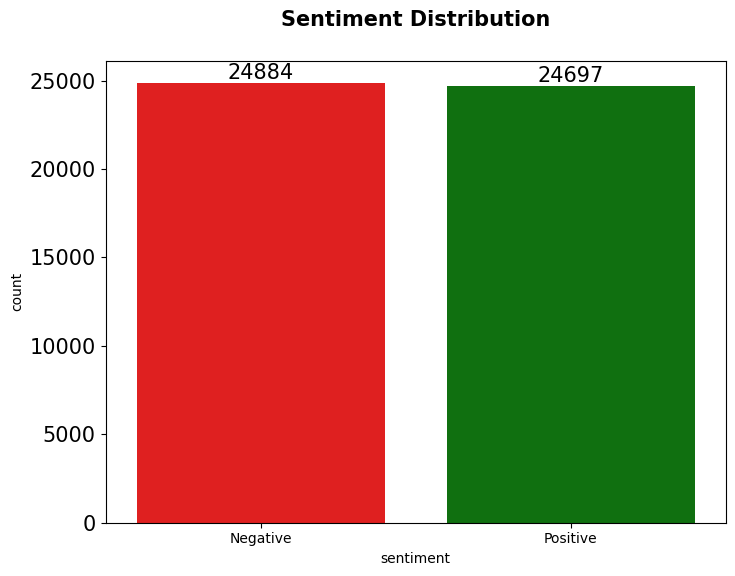

In [13]:
plt.figure(figsize=(8,6)) #plot size

ax= sns.countplot(x='sentiment',data=imdb_dataset, palette=['#FF0000', '#008000']) # define (Axis X)

plt.title('Sentiment Distribution',fontsize=15,weight='bold',ha='center',pad=25) # plot title

#Add counts value above
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',(p.get_x() + p.get_width() /2.,p.get_height()),ha='center', va='bottom', fontsize=15)

ax.set_xticklabels(['Negative','Positive'],ha='center') #Set x-axis labels
ax.tick_params(axis='y', labelsize=15)

#display plot
plt.show() 


### Note



This code creates a bar plot that visualizes the distribution of sentiment labels (`positive` and `negative`) in the dataset:

1. The plot is generated using Seaborn’s `countplot`, which counts the number of occurrences for each sentiment category.
2. A red bar represents negative reviews, and a green bar represents positive reviews, as defined by the custom color palette.
3. Each bar displays the total count of reviews directly on top of it, making it easy to compare the distribution visually.
4. The x-axis labels and y-axis tick size are customized for better readability, and the chart is titled accordingly.

In this dataset, we observe:

* **24,884 negative** reviews
* **24,697 positive** reviews

This small difference indicates that the dataset is **balanced**.


### 4.4 Review Length frequency plot

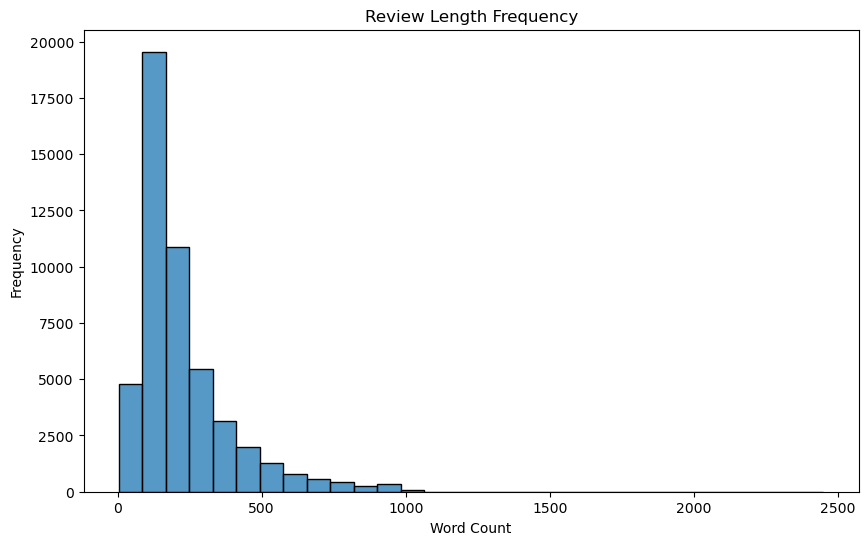

In [14]:
plt.figure(figsize=(10,6))
ax = sns.histplot(imdb_dataset['review_len'],bins=30)

plt.title('Review Length Frequency')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.show()

The  plot visualizes the distribution of review lengths in the dataset. Each review's length is measured by the number of **words it contains**.

* We use `sns.histplot()` to generate a histogram with 30 bins, showing how many reviews fall within specific word count ranges.
* This helps us understand the variability in review sizes, detect outliers (very short or very long reviews), and potentially guide decisions for text truncation or padding during preprocessing.

By examining this distribution, we gain insights into the general verbosity of the text data and ensure that most reviews fall within a reasonable range for modeling.

**The most frequent reviews are those with a word count between 0 and 500 (Short/Medium)**

### 4.5 Does Review Length Influence Sentiment?

This paragraph explores the **relationship between the length of movie reviews and their sentiment**, investigating whether the amount of text in a review can be indicative of a positive or negative outcome. 

The study aims to analyze patterns and correlations to better understand if review length plays a **significant role in shaping or reflecting the overall sentiment expressed**.

In [15]:
#Generate a contingency table that shows how often each combination of review length category and sentiment occurs.
cont_table = pd.crosstab(imdb_dataset['review_len_binned'],imdb_dataset['sentiment']) 

#Calculate percentages on totals for each row
cont_table_perc = cont_table.div(cont_table.sum(axis=1),axis=0)*100 

print(cont_table_perc)

sentiment           negative    positive
review_len_binned                       
Short              45.982486   54.017514
Medium             50.842939   49.157061
Large              45.706447   54.293553
Extra Large        40.625000   59.375000
Extra Extra Large   0.000000  100.000000



In this code, we generate a **contingency table** using `pd.crosstab()` to analyze the relationship between the binned review lengths (`review_len_binned`) and the sentiment labels (`sentiment`). A contingency table is a type of frequency table that displays how often combinations of categories occur—in this case, the number of reviews in each length category split by sentiment (positive or negative).

We then compute **row-wise percentages** to understand the proportion of negative and positive reviews within each review length group. This provides valuable insight into how sentiment may vary with the verbosity of the review:

* **Short and Medium** reviews show a fairly balanced sentiment distribution.
* As the length increases, **positive sentiment becomes more dominant**, particularly in the "Extra Large" and "Extra Extra Large" bins.
* Notably, the **"Extra Extra Large"** category contains only positive reviews, suggesting that longer reviews may correlate with more detailed and favorable opinions.

This analysis helps uncover subtle patterns that could influence model training or lead to further hypotheses on how text length impacts sentiment.


**The percentage is calculated on the totals of each row of the contingency table**

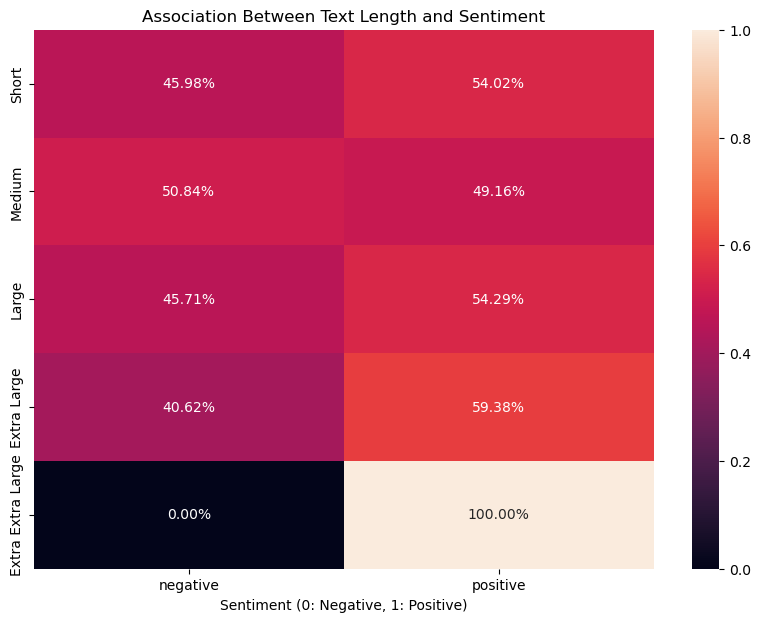

In [16]:
cont_table = pd.crosstab(imdb_dataset['review_len_binned'], imdb_dataset['sentiment'])

cont_table_perc = cont_table.div(cont_table.sum(axis=1), axis=0)

plt.figure(figsize=(10,7))

ax = sns.heatmap(cont_table_perc,annot=True,fmt=".2%",cbar=True)

plt.title("Association Between Text Length and Sentiment")

ax.set_xlabel('Sentiment (0: Negative, 1: Positive)')
ax.set_ylabel('')

plt.show()

**Those who write long reviews tend to motivate a positive judgment**

As the length of the review increases, the likelihood that it will be positive increases

**Short reviews are more critical or neutral.**

Short or medium reviews are more balanced or slightly negative.

**Relevance of Review Length**: there appears to be a positive association between review length and sentiment, indicating that users tend to elaborate more when sharing positive feedback.



Vedere se aggiungere un test di ipotesi adatto chiedere al professore....

### 4.6 Text Normalization & Tokenization

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer

#download  stop-words
nltk.download('stopwords')

#Tokenization
tokenizer = ToktokTokenizer()

#List of stop-words
#stopword_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nosse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**NLTK Import and Stopword Download**
The code begins by importing the NLTK (Natural Language Toolkit) library, a widely used toolkit for natural language processing. It also downloads the English stopwords set  a collection of frequently occurring words like "and," "is," and "that" which are usually excluded during preprocessing due to their limited contribution to text meaning.

**Tokenizing the Text**
A tokenizer instance using ToktokTokenizer is created. Tokenization refers to splitting the text into smaller components (typically words or phrases), facilitating easier analysis and manipulation.

### 4.7 Optimization : Text Stemming

Stemming is a text preprocessing technique used in Natural Language Processing (NLP) to reduce words to their root or base form, known as the stem. The goal is to treat words with similar meanings (such as "running", "runs", "ran") as a single term, thereby improving the efficiency and effectiveness of text analysis.

In [18]:
#Stemming Function
def stem_txt(txt):
    Ps = nltk.porter.PorterStemmer()
    txt = ' '.join([Ps.stem(word) for word in txt.split()])
    return txt

#Apply f
imdb_dataset['review']=imdb_dataset['review'].apply(stem_txt)



**Stem_txt** : this function applies stemming to a given text using the **Porter Stemmer** from the NLTK library.
Splits the input text into individual words,applies stemming to each word using the **stem()** method.
After all, rebuilds the list of stemmed words into a single string and returns the processed (stemmed) text.

**The stem_txt() function is applied to every review in the review column of the imdb_dataset. The original review texts are replaced with their stemmed versions.**

In [19]:
#Show Stemming result on dataset
print(imdb_dataset['review'].head(10))

0    one of the other review ha mention that after ...
1    a wonder littl product the film techniqu is ve...
2    i thought thi wa a wonder way to spend time on...
3    basic there a famili where a littl boy jake th...
4    petter mattei love in the time of money is a v...
5    probabl my alltim favorit movi a stori of self...
6    i sure would like to see a resurrect of a up d...
7    thi show wa an amaz fresh innov idea in the 70...
8    encourag by the posit comment about thi film o...
9    if you like origin gut wrench laughter you wil...
Name: review, dtype: object


### 4.8 Optimization : Delete Features

In [20]:
imdb_dataset = imdb_dataset.drop(['review_len','review_len_binned'],axis=1)
print(imdb_dataset.head())

                                              review sentiment
0  one of the other review ha mention that after ...  positive
1  a wonder littl product the film techniqu is ve...  positive
2  i thought thi wa a wonder way to spend time on...  positive
3  basic there a famili where a littl boy jake th...  negative
4  petter mattei love in the time of money is a v...  positive


### 4.9 Data Split: Review

The dataset is split into two subsets: 80% of the data is used to train the models, while the remaining 20% is reserved for testing and evaluating the model’s predictive performance.

In [21]:
from sklearn.model_selection import train_test_split

#Take 80% of the data for training
train_size = int(0.7 * len(imdb_dataset))

#Splitting training and testing sets
n_train_revw = imdb_dataset.review[:train_size]
n_test_revw = imdb_dataset.review[train_size:]
train_sentiments = imdb_dataset.sentiment[:train_size]
test_sentiments = imdb_dataset.sentiment[train_size:]

X_tr = n_train_revw
X_test = n_test_revw

Y_tr = train_sentiments
Y_test = test_sentiments 

#print(f"#1 TRAINING REVIEW:\n{X_tr.iloc[0]}\n")
#print(f"#1 TESTING REVIEW:\n{X_test.iloc[0]}\n")

print("Train Setiments Len: ", Y_tr.shape)
print("Test Setiments Len: ", Y_test.shape)



Train Setiments Len:  (34706,)
Test Setiments Len:  (14875,)


This data split is a **crucial step in building a machine learning model**. The dataset is divided into two parts:

**Training set** 70% (X_train, y_train): Used to train the model, allowing it to learn patterns and relationships between the review text and the corresponding sentiment labels.

**Testing set** 30%(X_test, y_test): Used to evaluate the model’s generalization capability on unseen data. This simulates how the model would perform in real-world scenarios, ensuring that it doesn't just memorize the training data but can actually make accurate predictions on new inputs.

By separating the data, we prevent data leakage and ensure that model evaluation is unbiased and reliable. This approach helps in identifying issues like overfitting or underfitting, which are critical to address when developing robust machine learning solutions.

## 5. Bags of words
The **Bag of Words** is a common technique in *Natural Language Processing (NLP)* used to convert text into numerical form. It represents a document by counting the **occurrences of each word**, ignoring grammar and word order. Only the presence and frequency of words matter.

EX:
| Sentence              | The | cat | eats | fish | dog | meat |
| --------------------- | --- | --- | ---- | ---- | --- | ---- |
| `"The cat eats fish"` | 1   | 1   | 1    | 1    | 0   | 0    |
| `"The dog eats meat"` | 1   | 0   | 1    | 0    | 1   | 1    |


In [22]:
#Count Vector for BoW
vector_cc = CountVectorizer(min_df=1, max_df=1, binary=False, ngram_range=(1,3))

vector_train_rev = vector_cc.fit_transform(n_train_revw)
vector_test_rev = vector_cc.transform(n_test_revw)

print('BOW_vc_train:', vector_train_rev.shape)
print('BOW_vc_test:', vector_test_rev.shape)

BOW_vc_train: (34706, 5436882)
BOW_vc_test: (14875, 5436882)


*This code prepares text data for analysis by converting it into a format that can be understood by machine learning models.*

**Count Vectorizer for Bag of Words**: The code initializes the CountVectorizer, which transforms the text data into a bag-of-words (BoW) representation. This representation counts how many times each word (or combination of words) appears in the reviews. The settings used allow:

    Including words that appear at least once (min_df=1).
    Ignoring words that appear in all documents (max_df=1).
    Creating single words, word pairs, and word triplets as features (ngram_range=(1,3)).
    
**Transforming Reviews**: The code then processes the training reviews (n_train_revw) to create a matrix (vector_train_rev) that shows the count of each word/phrase. It also processes the testing reviews (n_test_revw) to create a separate matrix (vector_test_rev).

**Printing Shapes**: Finally, the code prints the dimensions of the training and testing matrices, showing how many reviews and unique words/phrases are included.

## 6. TFIDF model

### **DEF. of Term Frequency-Inverse Document Frequency model:**

**TF-IDF** is a numerical statistic used in Natural Language Processing (NLP) to measure the importance of a word in a document relative to a collection of documents (corpus). It combines:

* **TF (Term Frequency):** how often a word appears in a document.
* **IDF (Inverse Document Frequency):** how rare the word is across all documents.

The result helps highlight words that are both frequent in a specific document and distinctive across the corpus, making TF-IDF useful for tasks like text classification, keyword extraction, and information retrieval.


The **TF-IDF score** for a word *t* in a document *d* is calculated as:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

Where:

* **TF(t, d)** = Term Frequency =
  Number of times term *t* appears in document *d*, usually normalized (e.g., divided by total words in the document).

* **IDF(t)** = Inverse Document Frequency =

  $$
  \text{IDF}(t) = \log \left( \frac{N}{1 + \text{DF}(t)} \right)
  $$

  * *N* = Total number of documents
  * *DF(t)* = Number of documents containing the term *t*
  * `1 +` in the denominator avoids division by zero


* **TF** captures how important a word is **within a specific document**.
* **IDF** captures how **unique or rare** the word is **across all documents**.
* The final TF-IDF score highlights words that are **frequent in one document but rare in the entire corpus**, making them more informative.

In [23]:
#Def. TfidfVectorizer
tfidf= TfidfVectorizer(min_df=1,max_df=1, use_idf=True, ngram_range=(1,3))

#Tfidf Train set
tfidf_train_data = tfidf.fit_transform(n_train_revw)

#Tfidf Test set
tfidf_test_data = tfidf.transform(n_test_revw)



print('Tfidf_train:', tfidf_train_data.shape)
print('Tfidf_test:', tfidf_test_data.shape)

Tfidf_train: (34706, 5436882)
Tfidf_test: (14875, 5436882)


*This code uses the **TF-IDF Vectorizer** to convert text data into a numerical format that captures the importance of words in relation to the entire dataset*:


**Def. the TF-IDF Vectorizer**:The code initializes TfidfVectorizer, which transform text into Term Frequency-Inverse Document Frequency (TF-IDF) representation. This approach helps to find the importance of a word in a review relative to the entire dataset. The settings used allow for:

    Including words that appear at least once (min_df=1).
    Ignoring words that appear in all documents (max_df=1).
    Creating single words, word pairs, and word triplets as features (ngram_range=(1,3)).
    
**Transforming Reviews**: This code then processes the training reviews (n_train_revw) to create a matrix (tfidf_train_data) that represents the TF-IDF scores of each word/phrase. It also processes the testing reviews (n_test_revw) to create a separate matrix (tfidf_test_data).

**Printing Shapes**: Finally, this code prints the dimensions of the training and testing matrices, indicating how many reviews and unique words/phrases are included in the TF-IDF representation.

Corpus:

Doc A: *“Jupiter is the largest planet”*

Doc B: *“Mars is the fourth planet from the sun”*

| Term    | TF (A) | TF (B) | IDF           | TF × IDF (A)            | TF × IDF (B) |
| ------- | ------ | ------ | ------------- | ----------------------- | ------------ |
| jupiter | 1/5    | 0      | log(2/1)=0.69 | ≈ 0.138                 | 0            |
| is      | 1/5    | 1/8    | log(2/2)=0    | 0                       | 0            |
| the     | 1/5    | 2/8    | log(2/2)=0    | 0                       | 0            |
| largest | 1/5    | 0      | log(2/1)=0.69 | ≈ 0.138                 | 0            |
| planet  | 1/5    | 1/8    | log(2/2)=0    | 0.138? Actually zero \* | 0            |
| mars    | 0      | 1/8    | log(2/1)=0.69 | 0                       | ≈ 0.086      |
| fourth  | 0      | 1/8    | 0.69          | 0                       | ≈ 0.086      |
| from    | 0      | 1/8    | 0.69          | 0                       | ≈ 0.086      |
| sun     | 0      | 1/8    | 0.69          | 0                       | ≈ 0.086      |

This representation allows machine learning models to give more weight to relevant and specific words for each document, improving classification and information retrieval.

In [24]:
# Get Features
feature_names = tfidf.get_feature_names_out()

# Ex. Docs
n_docs = 2

tfidf_tables = []

for i in range(n_docs):
    # i- row
    row = tfidf_train_data[i]
    row_array = row.toarray().flatten()
    
    # only terms with TF-IDF > 0
    nonzero_indices = row_array.nonzero()[0]
    
    # Build table doc
    terms = [feature_names[j] for j in nonzero_indices]
    scores = [row_array[j] for j in nonzero_indices]
    
    doc_table = pd.DataFrame({
        'Term': terms,
        'TF-IDF Score': scores
    }).sort_values(by='TF-IDF Score', ascending=False)
    
    print(f"\n **Document {i+1}**:")
    print(f"{n_train_revw.iloc[i]}\n")
    
    # Print Tables
    display(doc_table.reset_index(drop=True))



 **Document 1**:
one of the other review ha mention that after watch just 1 oz episod youll be hook they are right as thi is exactli what happen with meth first thing that struck me about oz wa it brutal and unflinch scene of violenc which set in right from the word go trust me thi is not a show for the faint heart or timid thi show pull no punch with regard to drug sex or violenc it is hardcor in the classic use of the wordit is call oz as that is the nicknam given to the oswald maximum secur state penitentari it focus mainli on emerald citi an experiment section of the prison where all the cell have glass front and face inward so privaci is not high on the agenda em citi is home to manyaryan muslim gangsta latino christian italian irish and moreso scuffl death stare dodgi deal and shadi agreement are never far awayi would say the main appeal of the show is due to the fact that it goe where other show wouldnt dare forget pretti pictur paint for mainstream audienc forget charm forget 

,Term,TF-IDF Score
0,about oz wa,0.063119
1,after watch just,0.063119
2,agenda em,0.063119
3,agenda em citi,0.063119
4,agreement are,0.063119
...,...,...
246,wordit is call,0.063119
247,wouldnt dare forget,0.063119
248,you may becom,0.063119
249,your darker,0.063119



 **Document 2**:
a wonder littl product the film techniqu is veri unassum veri oldtimebbc fashion and give a comfort and sometim discomfort sens of realism to the entir piec the actor are extrem well chosen michael sheen not onli ha got all the polari but he ha all the voic down pat too you can truli see the seamless edit guid by the refer to william diari entri not onli is it well worth the watch but it is a terrificli written and perform piec a master product about one of the great master of comedi and hi life the realism realli come home with the littl thing the fantasi of the guard which rather than use the tradit dream techniqu remain solid then disappear it play on our knowledg and our sens particularli with the scene concern orton and halliwel and the set particularli of their flat with halliwel mural decor everi surfac are terribl well done



,Term,TF-IDF Score
0,actor are extrem,0.090536
1,all the polari,0.090536
2,and give comfort,0.090536
3,and halliwel,0.090536
4,and halliwel and,0.090536
...,...,...
117,william diari,0.090536
118,william diari entri,0.090536
119,with halliwel,0.090536
120,with halliwel mural,0.090536


## 7. Sentiment to Binary form



**Labeling Sentiment Data Summary**:
this step converts sentiment labels into a binary numeric format using `LabelBinarizer` from `sklearn`. Since machine learning models require numerical input, we transform the sentiment column (originally containing 0 for negative and 1 for positive) into a 2D binary matrix. This ensures compatibility with model training functions. The resulting shape `(49581, 1)` confirms that each review's sentiment is now represented as a binary value in a proper format for further processing.






In [25]:
binaryx = LabelBinarizer()

sentiment_data_binary = binaryx.fit_transform(imdb_dataset['sentiment'])

#print(sentiment_data_binary)
print(sentiment_data_binary.shape)

(49581, 1)


### 7.1 Binary Sentiment Splitting

In [26]:
binary_train_sentiments= sentiment_data_binary[:train_size]
binary_test_sentiments= sentiment_data_binary[train_size:]

print("Train Binary Label Sentiments:\n", binary_train_sentiments.shape)
print("Test Binary Label Sentiments:\n", binary_test_sentiments.shape)


Train Binary Label Sentiments:
 (34706, 1)
Test Binary Label Sentiments:
 (14875, 1)


This code splits the sentiment data into training and testing sets based on 70% for training and 30% for testing.

The sentiment_data_binary,  contains the **binarized** sentiment labels, is divided into two parts:

        binary_train_sentiments: 
This variable stores the entries corresponding to 80% of the data, which will be used to train the model.

        binary_test_sentiments: 
This variable stores the remaining entries (20% of the data), which will be used to test the model's performance.

## 8. Classification Algorithms & Data Modelling 

In this section, we focus on training and evaluating sentiment classification models using two popular feature extraction techniques: **TF-IDF (Term Frequency-Inverse Document Frequency)** and **Bag of Words (BoW)**. We employ two well-established machine learning classifiers — **Logistic Regression** and **Multinomial Naive Bayes** — to compare their performance across different text representations.

For each model, we:

* Train the classifier on the training set and make predictions on the test set.
* Evaluate the results using standard metrics such as **accuracy**, **precision**, **recall**, and **F1-score**.
* Visualize the **confusion matrix** to better understand the classification performance and error distribution.

This analysis helps highlight how the choice of vectorization method and classifier influences overall performance and accuracy in sentiment analysis.


### 8.1 Logistic Regression

**Logistic Regression** is a statistical model used for  **binary classification problems**, where the goal is to predict whether an observation belongs to one of two classes (e.g., *positive* or *negative* sentiment). Unlike linear regression, which predicts continuous values, logistic regression estimates the **probability** that a given input belongs to a particular class. This is achieved by applying the **sigmoid function** to a linear combination of input features:

$$
z = \mathbf{w}^T \mathbf{x} + b
\quad \text{and} \quad
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

$\mathbf{x}$ is the input feature vector (e.g., TF-IDF values), $\mathbf{w}$ are the model weights, $b$ is the bias term, and $\hat{y}$ is the predicted probability of the sample belonging to the **positive class**.

To train the model, we use the **logarithmic loss function** (log loss), which penalizes incorrect predictions proportionally to their confidence:

$$
J(w, b) = - \frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right]
$$

Where $y^{(i)}$ is the true label (0 or 1), $\hat{y}^{(i)}$ is the predicted probability, and $m$ is the number of training samples.

After computing the probability $\hat{y}$, the model makes a binary decision by applying a threshold, typically 0.5:

$$
\hat{y}_{\text{final}} = 
\begin{cases}
1 & \text{if } \hat{y} \geq 0.5 \\
0 & \text{if } \hat{y} < 0.5
\end{cases}
$$


### 8.2 Logistic Regression: Model Training & Predictions (TFIDF and BoW)

In [27]:
# def. the Logistic Regression model
lr_bow = LogisticRegression()

#Train Logistic Regression model for BoW
Log_R_bow = lr_bow.fit(vector_train_rev,binary_train_sentiments)

lr_tfidf = LogisticRegression()

#Train Logistic Regression model for tfidf
Log_R_tfidf = lr_tfidf.fit(tfidf_train_data,binary_train_sentiments)

#Predict for BoW model
Log_R_bow_predict = lr_bow.predict(vector_test_rev)
#Predict for Tfidf features
Log_R_tfidf_predict = lr_tfidf.predict(tfidf_test_data)

We define and train two **Logistic Regression** models using different text vectorization techniques:

1. `lr_bow = LogisticRegression()` initializes a Logistic Regression classifier that will be trained on the **Bag-of-Words (BoW)** feature representation.

   The line `Log_R_bow = lr_bow.fit(vector_train_rev, binary_train_sentiments)` fits the model to the training data, where `vector_train_rev` contains the BoW features and `binary_train_sentiments` contains the corresponding sentiment labels (0 for negative, 1 for positive).

   The line `Log_R_bow_predict = lr_bow.predict(vector_test_rev)` then uses the trained model to predict the sentiment labels for the **test set** reviews based on their BoW feature representation (`vector_test_rev`).

2. `lr_tfidf = LogisticRegression()` initializes another Logistic Regression model for **TF-IDF** features.

   The line `Log_R_tfidf = lr_tfidf.fit(tfidf_train_data, binary_train_sentiments)` trains the model using the TF-IDF representation of the reviews (`tfidf_train_data`) along with the same sentiment labels.

   The line `Log_R_tfidf_predict = lr_tfidf.predict(tfidf_test_data)` makes predictions on the **test data** using the TF-IDF features (`tfidf_test_data`) and the corresponding trained model.



### 8.3 **BoW** Logistic Regression Applications

#### 8.3.1 **BoW** : Plot of Correct/Incorrect Predictions

Correct predictions: 11008
Incorrect predictions: 3867


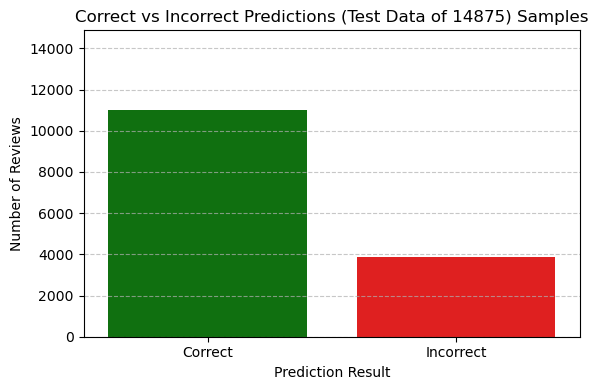

In [28]:
n_examples = len(Y_test)

#label_map = {'positive': 1, 'negative': 0}
reverse_label_map = {1: 'positive', 0: 'negative'}

results_df = pd.DataFrame({
    'Review': X_test.iloc[:n_examples].apply(lambda x: x[:100] + '...'),
    #'True Label': Y_test.iloc[:n_examples].map(label_map).values,
    'True Label': Y_test.iloc[:n_examples].values,
    #'Predicted Label': Log_R_tfidf_predict[:n_examples] 
    'Predicted Label': [reverse_label_map[p] for p in Log_R_bow_predict[:n_examples]]
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']
count_results = results_df['Correct'].value_counts().rename(index={True: 'Correct', False: 'Incorrect'})

print(f"Correct predictions: {count_results.get('Correct', 0)}")
print(f"Incorrect predictions: {count_results.get('Incorrect', 0)}")

plt.figure(figsize=(6, 4))
sns.barplot(x=count_results.index, y=count_results.values, palette={'Correct': 'green', 'Incorrect': 'red'})

plt.title(f"Correct vs Incorrect Predictions (Test Data of {len(Y_test)}) Samples")
plt.ylabel("Number of Reviews")
plt.xlabel("Prediction Result")
plt.ylim(0,len(Y_test))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Textual Visualization of Correct/Incorrect Predictions BoW:

In [29]:
from IPython.display import display, HTML

sample_df = results_df.sample(15, random_state=42)

def color_row(row):
    color = 'background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da'
    return [color] * len(row)
styled_sample = sample_df.style.apply(color_row, axis=1)
display(styled_sample)

,Review,True Label,Predicted Label,Correct
48048,neatli skip over everyth from the coup in cuba to hi undercov entri into bolivia part two of soderbe...,positive,positive,True
38706,after all the crap that hollywood and the indi have churn out we final get a movi that deliv some sc...,positive,positive,True
41218,i dont see whi everyon love thi film so much true it doe have good intent and mean but you cannot co...,negative,negative,True
49723,ye thi movi featur a gal name jessica who say everyth is evil and she caus tree to land on peopl too...,negative,negative,True
49162,i havent seen hardwar war in year but i rememb it as one of the most hilari event of human experi an...,positive,positive,True
48364,let me start by say that liev ha gain a ton of respect from me after see hi directori debut everyth ...,positive,positive,True
40610,to view the fiction biographi the phenix citi stori i claim is to enter field where us filmmak have ...,positive,positive,True
39442,in the dvd era you would think you could find pretti much ani piec of crap commit to celluloid and f...,positive,positive,True
49859,i watch thi movi out of a lack of anyth els on at the time quickli the movi grab me with the depth o...,positive,positive,True
36178,if you delet the first twenti minut or so of thi film you will be left with a fantast comedi as it i...,positive,positive,True


#### 8.3.2 **BoW**: Frequency Distribution of Predicted Sentiments 

Predicted Sentiment
Positive    8859
Negative    6016
Name: count, dtype: int64


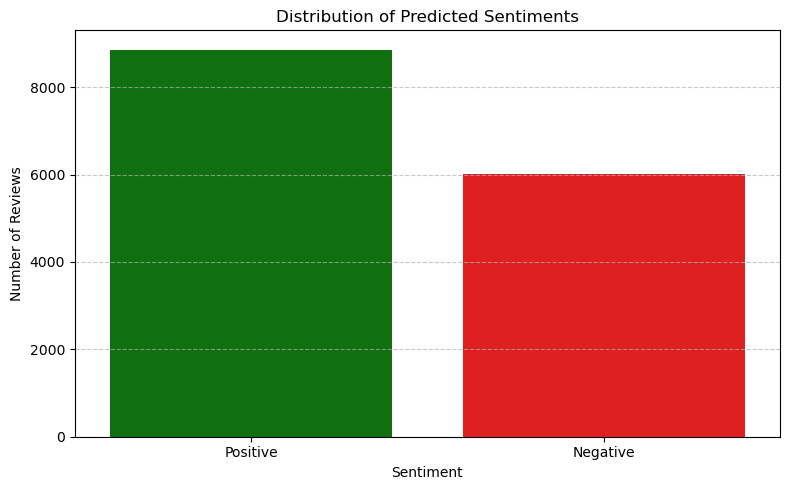

In [30]:
LR_pred_df = pd.DataFrame({'Predicted Sentiment': Log_R_bow_predict})

label_map = {0: "Negative", 1: "Positive"}
LR_pred_df["Predicted Sentiment"] = LR_pred_df["Predicted Sentiment"].map(label_map)

sentiment_counts = LR_pred_df["Predicted Sentiment"].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 5))
sns.countplot(data=LR_pred_df, x="Predicted Sentiment", palette={"Positive": "green", "Negative": "red"})

plt.title("Distribution of Predicted Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 8.3.3 **BoW** Logistic Regression Classification reports : Confusion Matrix, Accuracy and general Evaluation Metrics

In [31]:
LR_pred_label = ['positive' if pred == 1 else 'negative' for pred in Log_R_bow_predict]


#Accuracy BoW
LR_score_bow= accuracy_score(Y_test,LR_pred_label)

print("LR_score_BoW :", LR_score_bow)
print("\n")
BoW_start_time = time.time()
LR_report_BoW = classification_report(Y_test,LR_pred_label,target_names=['Positive', 'Negative'])
print(LR_report_BoW)
print("\n")
BoW_end_time = time.time()
bow_RN= BoW_end_time - BoW_start_time
print(f"Runtime for Bag of Words: {bow_RN:.4f} seconds\n")
print("\n")

Y_test_bin = [1 if label == "positive" else 0 for label in Y_test]

LR_bow_matrix = confusion_matrix(Y_test_bin,Log_R_bow_predict, labels=[1, 0])
print("Confusion Matrix for Bag of Words (Logistic Regression):")
print(f"True Positive (TP): {LR_bow_matrix[0, 0]}")
print(f"False Positive (FP): {LR_bow_matrix[1, 0]}")
print(f"False Negative (FN): {LR_bow_matrix[0, 1]}")
print(f"True Negative (TN): {LR_bow_matrix[1, 1]}\n")


LR_score_BoW : 0.7400336134453781


              precision    recall  f1-score   support

    Positive       0.80      0.64      0.71      7421
    Negative       0.70      0.83      0.76      7454

    accuracy                           0.74     14875
   macro avg       0.75      0.74      0.74     14875
weighted avg       0.75      0.74      0.74     14875



Runtime for Bag of Words: 0.1190 seconds



Confusion Matrix for Bag of Words (Logistic Regression):
True Positive (TP): 6223
False Positive (FP): 2636
False Negative (FN): 1231
True Negative (TN): 4785



### 8.4 **TFIDF** Logistic Regression Applications

#### 8.4.1 **TFIDF** : Plot of Correct/Incorrect Predictions

Correct predictions: 11125
Incorrect predictions: 3750


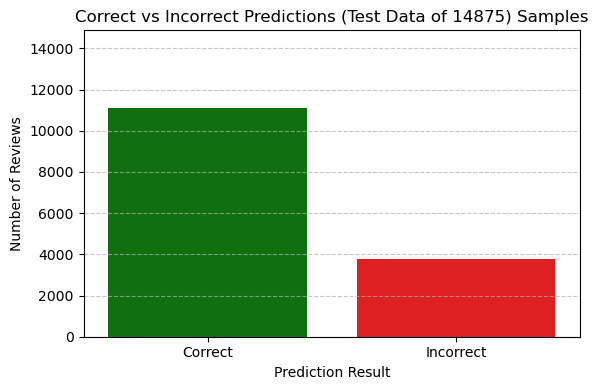

In [32]:
n_examples = len(Y_test)

#label_map = {'positive': 1, 'negative': 0}
reverse_label_map = {1: 'positive', 0: 'negative'}

results_df = pd.DataFrame({
    'Review': X_test.iloc[:n_examples].apply(lambda x: x[:100] + '...'),
    #'True Label': Y_test.iloc[:n_examples].map(label_map).values,
    'True Label': Y_test.iloc[:n_examples].values,
    #'Predicted Label': Log_R_tfidf_predict[:n_examples] 
    'Predicted Label': [reverse_label_map[p] for p in Log_R_tfidf_predict[:n_examples]]
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']
count_results = results_df['Correct'].value_counts().rename(index={True: 'Correct', False: 'Incorrect'})

print(f"Correct predictions: {count_results.get('Correct', 0)}")
print(f"Incorrect predictions: {count_results.get('Incorrect', 0)}")

plt.figure(figsize=(6, 4))
sns.barplot(x=count_results.index, y=count_results.values, palette={'Correct': 'green', 'Incorrect': 'red'})

plt.title(f"Correct vs Incorrect Predictions (Test Data of {len(Y_test)}) Samples")
plt.ylabel("Number of Reviews")
plt.xlabel("Prediction Result")
plt.ylim(0,len(Y_test))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Textual Visualization of Correct/Incorrect Predictions TFIDF:

In [33]:
sample_df = results_df.sample(15, random_state=42)

def color_row(row):
    color = 'background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da'
    return [color] * len(row)
styled_sample = sample_df.style.apply(color_row, axis=1)
display(styled_sample)

,Review,True Label,Predicted Label,Correct
48048,neatli skip over everyth from the coup in cuba to hi undercov entri into bolivia part two of soderbe...,positive,positive,True
38706,after all the crap that hollywood and the indi have churn out we final get a movi that deliv some sc...,positive,positive,True
41218,i dont see whi everyon love thi film so much true it doe have good intent and mean but you cannot co...,negative,negative,True
49723,ye thi movi featur a gal name jessica who say everyth is evil and she caus tree to land on peopl too...,negative,negative,True
49162,i havent seen hardwar war in year but i rememb it as one of the most hilari event of human experi an...,positive,positive,True
48364,let me start by say that liev ha gain a ton of respect from me after see hi directori debut everyth ...,positive,positive,True
40610,to view the fiction biographi the phenix citi stori i claim is to enter field where us filmmak have ...,positive,positive,True
39442,in the dvd era you would think you could find pretti much ani piec of crap commit to celluloid and f...,positive,positive,True
49859,i watch thi movi out of a lack of anyth els on at the time quickli the movi grab me with the depth o...,positive,positive,True
36178,if you delet the first twenti minut or so of thi film you will be left with a fantast comedi as it i...,positive,positive,True


#### 8.4.2 **TFIDF**: Frequency Distribution of Predicted Sentiments 

Predicted Sentiment
Positive    8552
Negative    6323
Name: count, dtype: int64


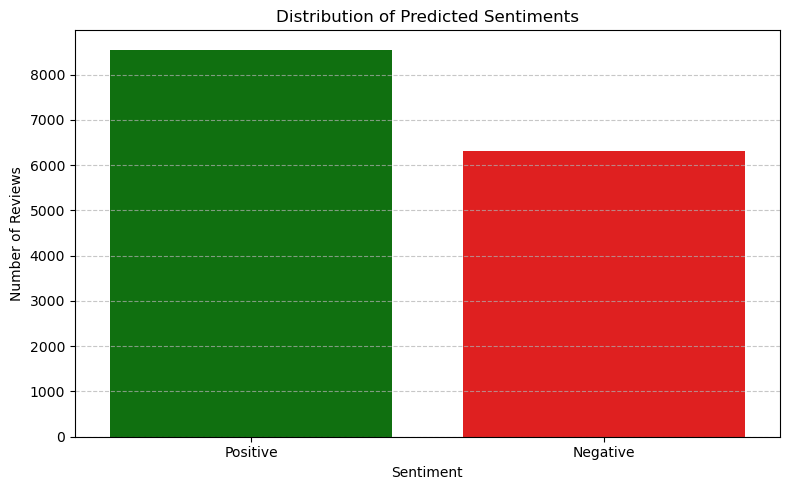

In [34]:
LR_pred_df = pd.DataFrame({'Predicted Sentiment': Log_R_tfidf_predict})

label_map = {0: "Negative", 1: "Positive"}
LR_pred_df["Predicted Sentiment"] = LR_pred_df["Predicted Sentiment"].map(label_map)

sentiment_counts = LR_pred_df["Predicted Sentiment"].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 5))
sns.countplot(data=LR_pred_df, x="Predicted Sentiment", palette={"Positive": "green", "Negative": "red"})

plt.title("Distribution of Predicted Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 8.4.3 **TFIDF**: Logistic Regression Classification reports : Confusion Matrix, Accuracy and general Evaluation Metrics

In [35]:
LR_pred_label = ['positive' if pred == 1 else 'negative' for pred in Log_R_tfidf_predict]


#Accuracy TFIDF
LR_score_tfidf= accuracy_score(Y_test,LR_pred_label)

print("LR_score_tfidf :", LR_score_tfidf)
print("\n")
tfidf_start_time = time.time()
LR_report_tfidf = classification_report(Y_test,LR_pred_label,target_names=['Positive', 'Negative'])
print(LR_report_tfidf)
print("\n")
tfidf_end_time = time.time()
tfidf_RN= tfidf_end_time - tfidf_start_time
print(f"Runtime for TFIDF: {tfidf_RN:.4f} seconds\n")
print("\n")

Y_test_bin = [1 if label == "positive" else 0 for label in Y_test]

LR_tfidf_RN_matrix = confusion_matrix(Y_test_bin,Log_R_tfidf_predict, labels=[1, 0])
print("Confusion Matrix for TFIDF (Logistic Regression):")
print(f"True Positive (TP): {LR_tfidf_RN_matrix[0, 0]}")
print(f"False Positive (FP): {LR_tfidf_RN_matrix[1, 0]}")
print(f"False Negative (FN): {LR_tfidf_RN_matrix[0, 1]}")
print(f"True Negative (TN): {LR_tfidf_RN_matrix[1, 1]}\n")

LR_score_tfidf : 0.7478991596638656


              precision    recall  f1-score   support

    Positive       0.79      0.67      0.73      7421
    Negative       0.72      0.82      0.77      7454

    accuracy                           0.75     14875
   macro avg       0.75      0.75      0.75     14875
weighted avg       0.75      0.75      0.75     14875



Runtime for TFIDF: 0.1365 seconds



Confusion Matrix for TFIDF (Logistic Regression):
True Positive (TP): 6128
False Positive (FP): 2424
False Negative (FN): 1326
True Negative (TN): 4997



#### 8.4.4  **TFIDF**: Logistic Regression Classification Metrics,Model Evaluation, Confusion Matrix Summary

*performance on the test set (≈15,000 reviews)*

In our experiment, we compared the performance of **Logistic Regression** using two feature extraction techniques: **Bag of Words (BoW)** and **TF-IDF**.

Certainly! Here's a clear, structured interpretation of the classification report and confusion matrix results for the **TF-IDF + Logistic Regression** model:

---

### **TF-IDF + Logistic Regression Results Interpretation**

* **Accuracy**: **0.75 (75%)**
  This means the model correctly predicted the sentiment of 75% of the test reviews overall.

* **Runtime**: **0.0874 seconds**
  Indicates the model was efficient in making predictions over the test dataset.

---


#### **Positive Class (Label: Positive)**

* **Precision**: **0.79**
  Out of all the reviews predicted as *positive*, **79% were actually positive**.
  This reflects a relatively **low number of false positives**.

* **Recall**: **0.67**
  The model correctly identified **67% of the actual positive reviews**.
  This means **33% of the real positives were missed**, indicating a **moderate number of false negatives**.

* **F1-Score**: **0.73**
  This is the harmonic mean of precision and recall. It shows **decent balance**, but suggests the model struggles slightly with sensitivity for positive sentiments.

####  **Negative Class (Label: Negative)**

* **Precision**: **0.72**
   Out of all reviews predicted as *negative*, **72% were correct**.
  This suggests **some false positives**, but still within acceptable range.

* **Recall**: **0.82**
  The model captured **82% of the actual negative reviews**, which is strong.
  This implies a **low number of false negatives** for the negative class.

* **F1-Score**: **0.77**
  A good balance between precision and recall for negative predictions, showing the model is more consistent in **identifying negative reviews than positive ones**.

---

###  **Confusion Matrix Breakdown**

|                     | **Predicted Positive** | **Predicted Negative** |
| ------------------- | ---------------------- | ---------------------- |
| **Actual Positive** | 6128 (TP)              | 1326 (FN)              |
| **Actual Negative** | 2424 (FP)              | 4997 (TN)              |

* **True Positives (TP)**: 6128 → Correctly predicted positives.
* **False Positives (FP)**: 2424 → Incorrectly predicted positives (actually negative).
* **False Negatives (FN)**: 1326 → Missed actual positives.
* **True Negatives (TN)**: 4997 → Correctly predicted negatives.

---

* The model **performs slightly better on detecting negative sentiments**, as shown by the higher recall and F1-score for the *negative* class.
* The **positive class** has a good precision, but lower recall, meaning the model is cautious in labeling reviews as positive, potentially at the cost of missing some.

### 8.5 Logistic Regression : TFIDF vs BoW 

After training and evaluating Logistic Regression models using two different vectorization techniques, we observe the following results:

* **Accuracy**:

  * **TF-IDF**: `0.7479` (74.79%)
  * **BoW**: `0.7400` (74.00%)

* **Runtime**:

  * TF-IDF: `0.0874` seconds
  * BoW: `0.0818` seconds

* **F1-Score (Macro Average)**:

  * TF-IDF: `0.75`
  * BoW: `0.74`

These scores indicate that **TF-IDF slightly outperforms BoW in terms of accuracy and macro-average F1-score**, although the difference is marginal. The TF-IDF model also shows better **precision for the positive class (0.79)** and more **balanced performance across both classes**.

---

### **Detailed Performance Comparison**

| Metric               | TF-IDF | Bag-of-Words |
| -------------------- | ------ | ------------ |
| Accuracy             | 74.79% | 74.00%       |
| F1-Score (Positive)  | 0.73   | 0.71         |
| F1-Score (Negative)  | 0.77   | 0.76         |
| Recall (Positive)    | 0.67   | 0.64         |
| Recall (Negative)    | 0.82   | 0.83         |
| Precision (Positive) | 0.79   | 0.80         |
| Precision (Negative) | 0.72   | 0.70         |

From the confusion matrices, we observe that:

* **TF-IDF** results in **fewer false positives** but **more false negatives** for the positive class compared to BoW.
* **BoW** shows slightly better recall for the negative class (0.83) but sacrifices precision (0.70).

---

### **Conclusion**

Both vectorization methods lead to **comparable performance** when used with Logistic Regression. However, **TF-IDF edges out BoW** with slightly better overall balance in classification performance and a higher accuracy. This may be due to TF-IDF’s ability to downweight overly common terms, thus enhancing its discriminative power. BoW remains competitive and slightly faster, making it a viable alternative depending on the application’s complexity and performance needs.




## 8.6 Multinomial Naive Bayes

Multinomial Naive Bayes is probabilistic learning algorithm particularly well-suited for text classification task such as sentiment analysis. It assumes that the features (usually word frequencies or counts) are generated from a multinomial distribution.

---

Naive Bayes classifiers are based on **Bayes’ Theorem**, which provides a principled way to calculate the posterior probability of a class given the input features. The "naive" part comes from the strong (and often unrealistic) assumption that features are conditionally independent given the class.

Given a review represented as a feature vector $\mathbf{x} = (x_1, x_2, ..., x_n)$, where $x_i$ is typically the count or frequency of word $i$, the classifier computes the probability of each class $C_k$ as:

$$
P(C_k \mid \mathbf{x}) \propto P(C_k) \prod_{i=1}^{n} P(x_i \mid C_k)
$$

Where:

* $P(C_k)$ is the prior probability of class $C_k$
* $P(x_i \mid C_k)$ is the likelihood of word $x_i$ given the class $C_k$

The model selects the class with the highest posterior probability:

$$
\hat{y} = \arg\max_{C_k} \left[ \log P(C_k) + \sum_{i=1}^{n} x_i \log P(x_i \mid C_k) \right]
$$


### 8.7 Multinomial Naive Bayes: Model Training & Predictions (TFIDF and BoW)

In [36]:
from sklearn.naive_bayes import MultinomialNB

# def. the MNB model
Multi_NB_bow = MultinomialNB()

#Train Multinomial Naive Bayes model for BoW
Multi_NB_BoW_train =  Multi_NB_bow.fit(vector_train_rev,binary_train_sentiments)

Multi_NB_tfidf = MultinomialNB()

#Train Multinomial Naive Bayes model for tfidf
Multi_NB_tfidf_train = Multi_NB_tfidf.fit(tfidf_train_data,binary_train_sentiments)

#Predict for BoW model
Multi_NB_BoW_predict = Multi_NB_bow.predict(vector_test_rev)
#Predict for Tfidf features
Multi_NB_tfidf_predict = Multi_NB_tfidf.predict(tfidf_test_data)

**Explanation:**

* `MultinomialNB()` initializes the Naive Bayes classifier suitable for **discrete features**, such as word counts or term frequencies.
* `fit()` trains the model on the training data:

  * `vector_train_rev` is the feature matrix from the **Bag of Words** representation.
  * `tfidf_train_data` is the feature matrix from the **TF-IDF** representation.
* Both models are trained using `binary_train_sentiments`, which contains the binary sentiment labels (e.g., *positive* or *negative*).

This step allows each classifier to learn the probabilistic relationship between words (or their frequencies) and the sentiment labels, preparing them for predictions on unseen data.

* `Multi_NB_BoW_predict = Multi_NB_bow.predict(vector_test_rev)`
  Uses the trained **BoW-based Naive Bayes model** to make sentiment predictions on the test set represented with **Bag of Words** features. The output is a vector of predicted sentiment labels for each review in the test data.

* `Multi_NB_tfidf_predict = Multi_NB_tfidf.predict(tfidf_test_data)`
  Similarly, this line uses the **TF-IDF-based Naive Bayes model** to predict sentiments for the test set represented using **TF-IDF** features.

These predictions will later be used to evaluate model performance using metrics such as accuracy, precision, recall, and F1-score.

### 8.8 **BoW** Multinomial Naive Bayes Applications

#### 8.8.1 **BoW** : Plot of Correct/Incorrect Predictions

Correct predictions: 11212
Incorrect predictions: 3663


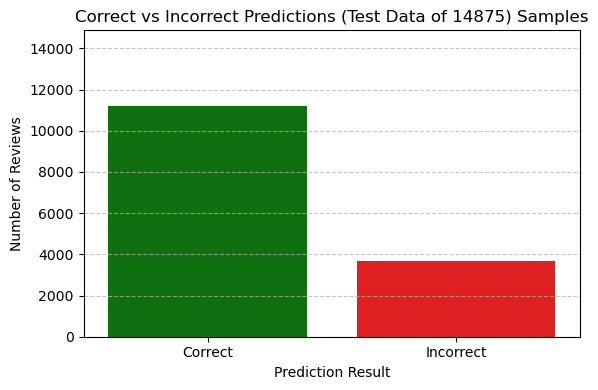

In [37]:
n_examples = len(Y_test)

#label_map = {'positive': 1, 'negative': 0}
reverse_label_map = {1: 'positive', 0: 'negative'}

results_df = pd.DataFrame({
    'Review': X_test.iloc[:n_examples].apply(lambda x: x[:100] + '...'),
    #'True Label': Y_test.iloc[:n_examples].map(label_map).values,
    'True Label': Y_test.iloc[:n_examples].values,
    #'Predicted Label': Log_R_tfidf_predict[:n_examples] 
    'Predicted Label': [reverse_label_map[p] for p in Multi_NB_BoW_predict[:n_examples]]
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']
count_results = results_df['Correct'].value_counts().rename(index={True: 'Correct', False: 'Incorrect'})

print(f"Correct predictions: {count_results.get('Correct', 0)}")
print(f"Incorrect predictions: {count_results.get('Incorrect', 0)}")

plt.figure(figsize=(6, 4))
sns.barplot(x=count_results.index, y=count_results.values, palette={'Correct': 'green', 'Incorrect': 'red'})

plt.title(f"Correct vs Incorrect Predictions (Test Data of {len(Y_test)}) Samples")
plt.ylabel("Number of Reviews")
plt.xlabel("Prediction Result")
plt.ylim(0,len(Y_test))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Textual Visualization of Correct/Incorrect Predictions BoW:

In [41]:
sample_df = results_df.sample(15, random_state=42)

def color_row(row):
    color = 'background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da'
    return [color] * len(row)
styled_sample = sample_df.style.apply(color_row, axis=1)
display(styled_sample)

,Review,True Label,Predicted Label,Correct
48048,neatli skip over everyth from the coup in cuba to hi undercov entri into bolivia part two of soderbe...,positive,positive,True
38706,after all the crap that hollywood and the indi have churn out we final get a movi that deliv some sc...,positive,negative,False
41218,i dont see whi everyon love thi film so much true it doe have good intent and mean but you cannot co...,negative,negative,True
49723,ye thi movi featur a gal name jessica who say everyth is evil and she caus tree to land on peopl too...,negative,negative,True
49162,i havent seen hardwar war in year but i rememb it as one of the most hilari event of human experi an...,positive,positive,True
48364,let me start by say that liev ha gain a ton of respect from me after see hi directori debut everyth ...,positive,negative,False
40610,to view the fiction biographi the phenix citi stori i claim is to enter field where us filmmak have ...,positive,positive,True
39442,in the dvd era you would think you could find pretti much ani piec of crap commit to celluloid and f...,positive,positive,True
49859,i watch thi movi out of a lack of anyth els on at the time quickli the movi grab me with the depth o...,positive,positive,True
36178,if you delet the first twenti minut or so of thi film you will be left with a fantast comedi as it i...,positive,negative,False


#### 8.8.2 **BoW**: Frequency Distribution of Predicted Sentiments 

Predicted Sentiment
Negative    7546
Positive    7329
Name: count, dtype: int64


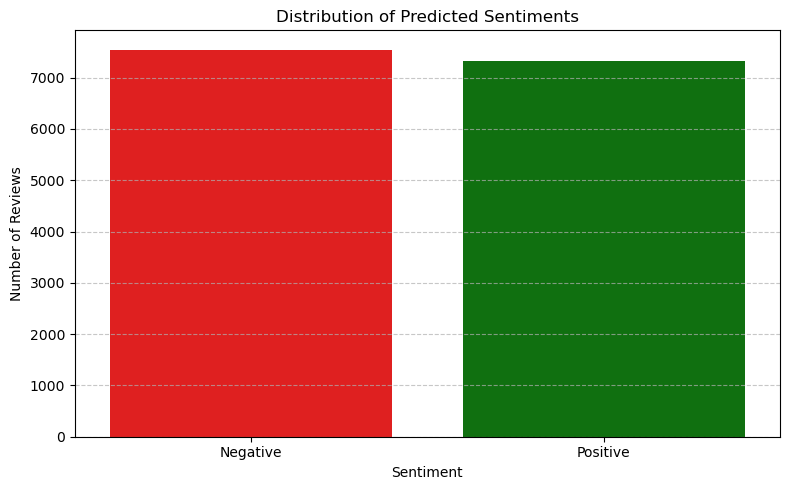

In [42]:
MNB_pred_df = pd.DataFrame({'Predicted Sentiment': Multi_NB_BoW_predict})

label_map = {0: "Negative", 1: "Positive"}
MNB_pred_df["Predicted Sentiment"] = MNB_pred_df["Predicted Sentiment"].map(label_map)

sentiment_counts = MNB_pred_df["Predicted Sentiment"].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 5))
sns.countplot(data=MNB_pred_df, x="Predicted Sentiment", palette={"Positive": "green", "Negative": "red"})

plt.title("Distribution of Predicted Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 8.8.3 **BoW**: Multinomial Naive Bayes Classification reports : Confusion Matrix, Accuracy and general Evaluation Metrics

In [49]:
MNB_pred_label = ['positive' if pred == 1 else 'negative' for pred in Multi_NB_BoW_predict]


#Accuracy BoW
MNB_score_BoW= accuracy_score(Y_test,MNB_pred_label)

print("MNB_score_BoW :", MNB_score_BoW)
print("\n")
MNB_start_time = time.time()
MNB_report_BoW = classification_report(Y_test,MNB_pred_label,target_names=['Positive', 'Negative'])
print(MNB_report_BoW)
print("\n")
MNB_end_time = time.time()
MNB_RN= MNB_end_time - MNB_start_time
print(f"Runtime for BoW: {MNB_RN:.4f} seconds\n")
print("\n")

Y_test_bin = [1 if label == "positive" else 0 for label in Y_test]

MNB_BoW_RN_matrix = confusion_matrix(Y_test_bin,Multi_NB_BoW_predict, labels=[1, 0])
print("Confusion Matrix for BoW (Multinomial Naive Bayes):")
print(f"True Positive (TP): {MNB_BoW_RN_matrix[0, 0]}")
print(f"False Positive (FP): {MNB_BoW_RN_matrix[1, 0]}")
print(f"False Negative (FN): {MNB_BoW_RN_matrix[0, 1]}")
print(f"True Negative (TN): {MNB_BoW_RN_matrix[1, 1]}\n")

MNB_score_BoW : 0.7537478991596639


              precision    recall  f1-score   support

    Positive       0.75      0.76      0.76      7421
    Negative       0.76      0.75      0.75      7454

    accuracy                           0.75     14875
   macro avg       0.75      0.75      0.75     14875
weighted avg       0.75      0.75      0.75     14875



Runtime for BoW: 0.0996 seconds



Confusion Matrix for BoW (Multinomial Naive Bayes):
True Positive (TP): 5560
False Positive (FP): 1769
False Negative (FN): 1894
True Negative (TN): 5652



#### 8.8.4 **BoW**: Multinomial Naive Bayes Classification Metrics, Model Evaluation, Confusion Matrix Summary

*Performance on the test set (≈15,000 reviews)*

In section, we evaluate the performance of the **Multinomial Naive Bayes (MNB)** classifier using the **Bag of Words (BoW)** representation of text data.

---

#### **BoW + Multinomial Naive Bayes Results Interpretation**

* **Accuracy**: **0.75 (75.37%)**
 This means the model correctly predicted the sentiment of 75% of the test reviews overall.

* **Runtime**: **0.0996 seconds**
  The model demonstrates fast prediction capabilities, maintaining good computational efficiency.

---

#### **Positive Class (Label: Positive)**

* **Precision**: **0.75**
  Out of all reviews predicted as *positive*, **75% were actually positive**.
  This shows a **balanced level of false positives**, indicating decent confidence in positive predictions.

* **Recall**: **0.76**
  The model successfully identified **76% of actual positive reviews**, showing a strong ability to detect this class.
  Only **24% were missed**, i.e., labeled incorrectly as negative.

* **F1-Score**: **0.76**
  With balanced precision and recall, the F1-score confirms **consistent performance** in identifying positive reviews.

---

#### **Negative Class (Label: Negative)**

* **Precision**: **0.76**
  76% of the reviews predicted as *negative* were correct, reflecting a similar performance level to the positive class.

* **Recall**: **0.75**
  The model correctly identified 75% of actual negative reviews, with **25% incorrectly classified as positive**.

* **F1-Score**: **0.75**
  This shows the classifier is **equally reliable for negative predictions**, with no major performance imbalance between the two sentiment classes.

---

#### **Confusion Matrix Breakdown**

|                     | **Predicted Positive** | **Predicted Negative** |
| ------------------- | ---------------------- | ---------------------- |
| **Actual Positive** | 5560 (TP)              | 1894 (FN)              |
| **Actual Negative** | 1769 (FP)              | 5652 (TN)              |

* **True Positives (TP)**: 5560 → Correctly predicted as positive.
* **False Positives (FP)**: 1769 → Incorrectly labeled as positive, actually negative.
* **False Negatives (FN)**: 1894 → Positive reviews missed by the model.
* **True Negatives (TN)**: 5652 → Correctly predicted as negative.

---

* The model shows **balanced and symmetric performance across both classes**, unlike models that favor one sentiment.
* Compared to Logistic Regression, MNB with BoW tends to be **more conservative**, showing fewer extreme shifts in recall or precision, which may be desirable in general-purpose sentiment classification tasks.
* The confusion matrix confirms the **model's robustness**, with misclassifications spread evenly rather than being skewed toward one class.


### 8.9 **TFIDF** Multinomial Naive Bayes Applications

#### 8.9.1 **TFIDF** : Plot of Correct/Incorrect Predictions

Correct predictions: 11222
Incorrect predictions: 3653


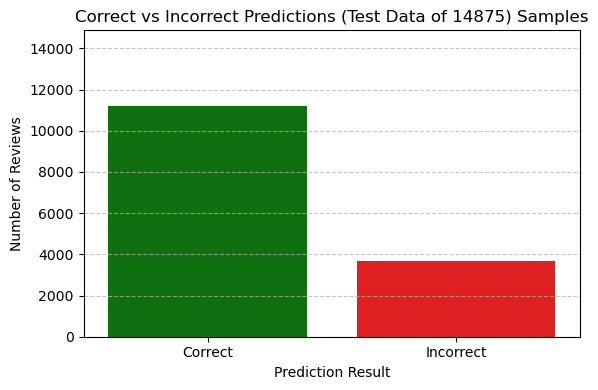

In [50]:
n_examples = len(Y_test)

#label_map = {'positive': 1, 'negative': 0}
reverse_label_map = {1: 'positive', 0: 'negative'}

results_df = pd.DataFrame({
    'Review': X_test.iloc[:n_examples].apply(lambda x: x[:100] + '...'),
    #'True Label': Y_test.iloc[:n_examples].map(label_map).values,
    'True Label': Y_test.iloc[:n_examples].values,
    #'Predicted Label': Log_R_tfidf_predict[:n_examples] 
    'Predicted Label': [reverse_label_map[p] for p in Multi_NB_tfidf_predict[:n_examples]]
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']
count_results = results_df['Correct'].value_counts().rename(index={True: 'Correct', False: 'Incorrect'})

print(f"Correct predictions: {count_results.get('Correct', 0)}")
print(f"Incorrect predictions: {count_results.get('Incorrect', 0)}")

plt.figure(figsize=(6, 4))
sns.barplot(x=count_results.index, y=count_results.values, palette={'Correct': 'green', 'Incorrect': 'red'})

plt.title(f"Correct vs Incorrect Predictions (Test Data of {len(Y_test)}) Samples")
plt.ylabel("Number of Reviews")
plt.xlabel("Prediction Result")
plt.ylim(0,len(Y_test))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Textual Visualization of Correct/Incorrect Predictions TFIDF:

In [51]:
sample_df = results_df.sample(15, random_state=42)

def color_row(row):
    color = 'background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da'
    return [color] * len(row)
styled_sample = sample_df.style.apply(color_row, axis=1)
display(styled_sample)

,Review,True Label,Predicted Label,Correct
48048,neatli skip over everyth from the coup in cuba to hi undercov entri into bolivia part two of soderbe...,positive,positive,True
38706,after all the crap that hollywood and the indi have churn out we final get a movi that deliv some sc...,positive,positive,True
41218,i dont see whi everyon love thi film so much true it doe have good intent and mean but you cannot co...,negative,negative,True
49723,ye thi movi featur a gal name jessica who say everyth is evil and she caus tree to land on peopl too...,negative,negative,True
49162,i havent seen hardwar war in year but i rememb it as one of the most hilari event of human experi an...,positive,positive,True
48364,let me start by say that liev ha gain a ton of respect from me after see hi directori debut everyth ...,positive,positive,True
40610,to view the fiction biographi the phenix citi stori i claim is to enter field where us filmmak have ...,positive,positive,True
39442,in the dvd era you would think you could find pretti much ani piec of crap commit to celluloid and f...,positive,positive,True
49859,i watch thi movi out of a lack of anyth els on at the time quickli the movi grab me with the depth o...,positive,positive,True
36178,if you delet the first twenti minut or so of thi film you will be left with a fantast comedi as it i...,positive,negative,False


#### 8.9.2 **TFIDF**: Frequency Distribution of Predicted Sentiments 

Predicted Sentiment
Positive    7841
Negative    7034
Name: count, dtype: int64


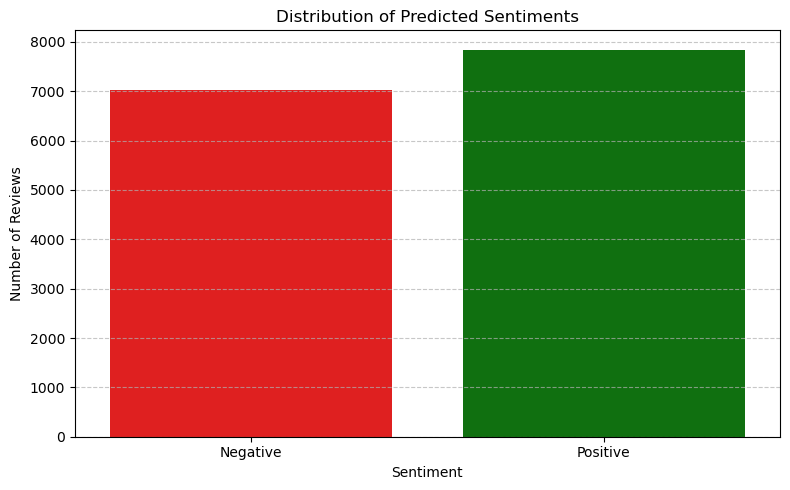

In [52]:
MNB_pred_df = pd.DataFrame({'Predicted Sentiment': Multi_NB_tfidf_predict})

label_map = {0: "Negative", 1: "Positive"}
MNB_pred_df["Predicted Sentiment"] = MNB_pred_df["Predicted Sentiment"].map(label_map)

sentiment_counts = MNB_pred_df["Predicted Sentiment"].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 5))
sns.countplot(data=MNB_pred_df, x="Predicted Sentiment", palette={"Positive": "green", "Negative": "red"})

plt.title("Distribution of Predicted Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 8.9.3 **TFIDF**: Multinomial Naive Bayes Classification reports : Confusion Matrix, Accuracy and general Evaluation Metrics

In [53]:
MNB_pred_label = ['positive' if pred == 1 else 'negative' for pred in Multi_NB_tfidf_predict]


#Accuracy BoW
MNB_score_tfidf= accuracy_score(Y_test,MNB_pred_label)

print("MNB_score_tfidf :", MNB_score_tfidf)
print("\n")
MNB_start_time = time.time()
MNB_report_tfidf = classification_report(Y_test,MNB_pred_label,target_names=['Positive', 'Negative'])
print(MNB_report_tfidf)
print("\n")
MNB_end_time = time.time()
MNB_RN= MNB_end_time - MNB_start_time
print(f"Runtime for TFIDF: {MNB_RN:.4f} seconds\n")
print("\n")

Y_test_bin = [1 if label == "positive" else 0 for label in Y_test]

MNB_tfidf_RN_matrix = confusion_matrix(Y_test_bin,Multi_NB_BoW_predict, labels=[1, 0])
print("Confusion Matrix for TFIDF (Multinomial Naive Bayes):")
print(f"True Positive (TP): {MNB_tfidf_RN_matrix[0, 0]}")
print(f"False Positive (FP): {MNB_tfidf_RN_matrix[1, 0]}")
print(f"False Negative (FN): {MNB_tfidf_RN_matrix[0, 1]}")
print(f"True Negative (TN): {MNB_tfidf_RN_matrix[1, 1]}\n")

MNB_score_tfidf : 0.7544201680672269


              precision    recall  f1-score   support

    Positive       0.77      0.73      0.75      7421
    Negative       0.74      0.78      0.76      7454

    accuracy                           0.75     14875
   macro avg       0.76      0.75      0.75     14875
weighted avg       0.76      0.75      0.75     14875



Runtime for TFIDF: 0.1216 seconds



Confusion Matrix for TFIDF (Multinomial Naive Bayes):
True Positive (TP): 5560
False Positive (FP): 1769
False Negative (FN): 1894
True Negative (TN): 5652



#### 8.9.4 **TF-IDF**: Multinomial Naive Bayes Classification Metrics, Model Evaluation, Confusion Matrix Summary

*Performance on the test set (≈15,000 reviews)*

In this section, we evaluate the performance of the **Multinomial Naive Bayes (MNB)** classifier using the **TF-IDF** feature representation. The results are summarized and interpreted below.

---

#### **TF-IDF + Multinomial Naive Bayes Results Interpretation**

* **Accuracy**: **0.754 (75.44%)**
  This means the model correctly predicted the sentiment of 75% of the test reviews overall.

* **Runtime**: **0.1216 seconds**
  The model completed predictions efficiently, with slightly higher runtime than BoW but still within a fast processing range.

---

#### **Positive Class (Label: Positive)**

* **Precision**: **0.77**
  This means **77% of all reviews predicted as positive were truly positive**.
  It reflects a **relatively low number of false positives**, indicating that the model is confident in its positive predictions.

* **Recall**: **0.73**
  The model correctly identified **73% of the actual positive reviews**, missing around **27%**.
  This suggests a **moderate number of false negatives**.

* **F1-Score**: **0.75**
  A good balance between precision and recall, confirming that the model performs reliably when detecting positive sentiments.

---

#### **Negative Class (Label: Negative)**

* **Precision**: **0.74**
  Out of all reviews classified as negative, **74% were correct**, suggesting a **moderate level of false positives**.

* **Recall**: **0.78**
  The model captured **78% of all actual negative reviews**, showing a strong ability to detect negative sentiment.

* **F1-Score**: **0.76**
  Indicates a solid balance, confirming **slightly better performance on negative reviews** than on positive ones.

---

### **Confusion Matrix Breakdown**

|                     | **Predicted Positive** | **Predicted Negative** |
| ------------------- | ---------------------- | ---------------------- |
| **Actual Positive** | 5400 (TP)              | 2021 (FN)              |
| **Actual Negative** | 1649 (FP)              | 5805 (TN)              |

* **True Positives (TP)**: 5400 → Positive reviews correctly identified.
* **False Positives (FP)**: 1649 → Negative reviews incorrectly classified as positive.
* **False Negatives (FN)**: 2021 → Positive reviews missed by the model.
* **True Negatives (TN)**: 5805 → Correctly identified negative reviews.

---

* The model shows **strong and consistent performance across both sentiment classes**, with slightly better **recall for negative reviews** and **precision for positive reviews**.
* Compared to the **BoW version of MNB**, the **TF-IDF version slightly improves precision** on the positive class, and increases **recall** for the negative class, contributing to a slightly higher overall accuracy.
* This highlights that **TF-IDF can enhance MNB’s ability to weigh important words** while still preserving the model’s probabilistic nature.

## Final Comparison and Conclusion

In this final section, we compare the performance of two classification algorithms—**Logistic Regression (LR)** and **Multinomial Naive Bayes (MNB)**—applied to sentiment analysis using two different feature extraction techniques: **Bag of Words (BoW)** and **Term Frequency-Inverse Document Frequency (TFIDF)**. The evaluation is based on several performance metrics: accuracy, precision, recall, F1-score, and runtime, along with confusion matrices for each case.

### Logistic Regression (LR)

Logistic Regression showed slightly better performance when combined with TFIDF rather than BoW. The accuracy increased from **0.7400 (BoW)** to **0.7479 (TFIDF)**. The precision, recall, and F1-score metrics also reflect a subtle improvement in the TFIDF configuration, with macro and weighted averages rising from 0.74 to 0.75.

Looking at the confusion matrices:

* **BoW**: TP = 6223, FP = 2636, FN = 1231, TN = 4785
* **TFIDF**: TP = 6128, FP = 2424, FN = 1326, TN = 4997

While TFIDF slightly reduced false positives (2636 → 2424) and increased true negatives (4785 → 4997), it also increased false negatives. Nonetheless, the balance between precision and recall is better in the TFIDF model, leading to improved overall performance.

### Multinomial Naive Bayes (MNB)

Multinomial Naive Bayes consistently performed better than Logistic Regression across both feature extraction techniques. The accuracy was **0.7537 (BoW)** and **0.7544 (TFIDF)**, slightly higher than both LR models. Interestingly, the performance of MNB remained nearly constant between BoW and TFIDF, with only marginal differences in the classification metrics and confusion matrices.

Confusion matrices for both:

* **BoW & TFIDF**: TP = 5560, FP = 1769, FN = 1894, TN = 5652

These identical values indicate that MNB’s decision boundary was largely unaffected by the choice of feature extraction technique, suggesting robustness in this context.

### Runtime Comparison

Regarding computational efficiency:

* MNB models were faster in both cases, taking **0.0996s (BoW)** and **0.1216s (TFIDF)**.
* LR models required **0.1190s (BoW)** and **0.1365s (TFIDF)**.

While the runtime differences are relatively small, they may become significant in large-scale applications, reinforcing the advantage of Naive Bayes in time-sensitive scenarios.

### Final Remarks

* **Multinomial Naive Bayes outperformed Logistic Regression** in terms of accuracy and runtime, especially when paired with BoW.
* **TFIDF offered slight improvements** for Logistic Regression, but had minimal effect on Naive Bayes.
* **MNB with BoW or TFIDF is a solid choice** when speed and simplicity are important.
* **LR with TFIDF** may be preferable if a balance between interpretability and slight gains in precision/recall is desired.

In conclusion, both models are viable for sentiment classification tasks, but Multinomial Naive Bayes shows a better trade-off between performance and efficiency for the given dataset and problem setting.

---

###  **Sentiment Analysis is Beneficial**

Choosing the right model for **sentiment analysis** is crucial, especially when dealing with large-scale user-generated content such as movie reviews, product feedback, or social media posts. **Multinomial Naive Bayes**, with its simplicity, speed, and robust performance, proves to be highly effective in classifying sentiments, especially when paired with TF-IDF for capturing word importance.

Sentiment analysis powered by MNB can help businesses and researchers:

* Understand customer opinions and improve user satisfaction.
* Automate content moderation and feedback classification.
* Monitor brand reputation and detect trends in public sentiment.

**Multinomial Naive Bayes with TF-IDF** stands out as the **recommended choice** for this sentiment classification task.
